# Trabajo Práctico 2: Reseñas de Películas - Ensamble

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

# Dependencias

In [1]:
!pip install unidecode

In [2]:
!pip install nltk
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 31.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import spacy

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import joblib

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_text

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from unidecode import unidecode

from sklearn import metrics

# Constants
SEED = 13

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from os.path import exists

Carga de los modelos con los mejores hiperparámetros encontrados.

In [5]:
rf = joblib.load("../modelos/ensamble/rf300iter.pkl")
gb = joblib.load("../modelos/ensamble/gb300iter.pkl")
kn = joblib.load("../modelos/ensamble/kn.pkl")
ab = joblib.load("../modelos/ensamble/ab10iter.pkl")
#ensemble = joblib.load("gb_rf_kn_ensemble.pkl")

# Preprocesamiento

Listado de posibles tareas a realizar:
- Remover mayúsculas.
- Remover tildes y signos ortográficos.
- Remover las reviews en inglés.
- Aplicar lemmatización con `spacy`
- Aplicar stemming con `nltk` (quizás es preferible simplemente usar lemmatización según recomendaciones de las clases prácticas)
- Remover stop words.

Cargo los CSV de training y de testing.

In [ ]:
df_train = pd.read_csv("train.csv", encoding='utf-8', on_bad_lines='warn')
df_test = pd.read_csv("test.csv", index_col=0)
df_train.columns

In [ ]:
df_train.value_counts()

Unnamed: 0  ID     review_es                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Creo una función para lematizar el texto con spacy.

In [8]:
nlp = spacy.load('es_core_news_sm')

def lemmatizer(text):
  sent = []
  doc = nlp(text)
  for word in doc:
    sent.append(word.lemma_)
  return " ".join(sent)

Lematizo el conjunto de test y train.

In [ ]:
df_train_copy2 = df_train.copy()
df_train_copy2["review_es"] = df_train_copy2.apply(lambda x: lemmatizer(x['review_es']), axis=1)

In [ ]:
# Lemmatize test
df_test["review_es"] = df_test.apply(lambda x: lemmatizer(x['review_es']), axis=1)

In [ ]:
df_lemmatized_copy = df_train_copy2.copy()

In [ ]:
df_train_copy2

,ID,review_es,sentimiento
0,0,uno de el otro critico haber mencionar que des...,positivo
1,1,uno pequeno pequeno produccion el tecnica de...,positivo
2,2,pensar que este ser uno manera maravilloso de ...,positivo
3,3,basicamente haber uno familia donde uno nino...,negativo
4,4,el amor en el tiempo de petter mattei ser ...,positivo
...,...,...,...
49995,49995,pensar que este pelicula hacer uno buen trabaj...,positivo
49996,49996,mala parcela mal dialogo malo actuacion ...,negativo
49997,49997,ser catolico ensenado en escuela primario parr...,negativo
49998,49998,ir a tener que estar en desacuerdo con el come...,negativo


Creo una función de preproceso para poner el texto en minusculas, remover diacriticos, simbolos y numeros.

In [7]:
def preprocess(
  text: str,
  lower: bool = True,
  remove_diacritics: bool = True,
  remove_symbols = True,
  remove_numbers = True
) -> str:
  if lower:
    text = text.lower()

  # Remove diacritics with the Unicode library.
  if remove_diacritics:
    text = unidecode(text)

  if remove_numbers:
    text = re.sub('[0-9]', '', text)

  # Replece every character that's not a letter or a number with a space.
  if remove_symbols:
    text = re.sub('[^a-zA-Z0-9ñÑÁÉÍÓÚáéíóúÜü]', ' ', text)

  text = text.strip()

  return text

Aplico el preproceso sobre el conjunto de train y test.

In [ ]:
df_train_copy1 = df_train.copy()
df_train_copy1["review_es"] = df_train_copy1["review_es"].apply(preprocess, args=(True, True, True, True))

df_train_copy2["review_es"] = df_train_copy2["review_es"].apply(preprocess, args=(True, True, True, True))
df_test["review_es"] = df_test["review_es"].apply(preprocess, args=(True, True, True, True))

Exporto los conjuntos a csv para no tener que hacer nuevamente el preproceso.

In [ ]:
df_train_copy2.to_csv("lemmatized_train.csv")
df_test.to_csv("lemmatized_test.csv")

## Busqueda y entrenamiento de Random Forest



Cargo los conjuntos de train y test (kaggle).

In [9]:
# Lematized datasets.
df_train = pd.read_csv("lemmatized_train.csv", encoding='utf-8', on_bad_lines='warn')
df_test = pd.read_csv("lemmatized_test.csv", index_col=0)

X_train, X_test, y_train, y_test = train_test_split(df_train.review_es, df_train.sentimiento, test_size=0.2, random_state=SEED, stratify=df_train.sentimiento)

Creo una lista de stopwords en Español y la utilizo al armar el TFIDFVectorizer.

In [10]:
stop_words = stopwords.words("spanish")
stop_words_tokenized = []
for w in stop_words:
    stop_words_tokenized = stop_words_tokenized + nltk.word_tokenize(preprocess(w))

In [11]:
vectorizer = TfidfVectorizer(
    preprocessor=preprocess,
    tokenizer=nltk.word_tokenize,
    token_pattern=None,
    max_df=0.7, # We could treat this one as a hyperparameter. It defines a threshold with which to ignore frequent words.
    min_df=0.01, # We could treat this one as a hyperparameter. It defines a threshold with which to ignore infrequent words.
    stop_words=stop_words_tokenized
)

Creo la bag of words sobre el conjunto de train y aplico el vectorizer entrenado al conjunto de test.

In [12]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train_vectorized

<40000x1573 sparse matrix of type '<class 'numpy.float64'>'
	with 2443284 stored elements in Compressed Sparse Row format>

Busco los mejores hiperparametros para un randomforest para el ensamble.

In [13]:
base_classifier = RandomForestClassifier(random_state=SEED)

max_depth = list(range(1,6))
max_depth.append(None)

folds=5
params_search = {
    'n_estimators': list(range(20, 101)),
    'criterion': ['gini','entropy','log_loss'],
    'max_depth': max_depth,
    'min_samples_split': [0.2, 0.4, 0.6, 0.8],
    'max_features': ['sqrt', 'log2', 10, 15]
}

kfoldcv = StratifiedKFold(n_splits=folds)


scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')

randomcv = RandomizedSearchCV(
      estimator=base_classifier,
      param_distributions = params_search,
      scoring=scorer_fn,
      cv=kfoldcv,
      n_iter=300
  )

if exists("rf300iter.pkl") == False:
  randomcv.fit(X_train_vectorized, y_train)

  best_classifier = randomcv.best_estimator_

  joblib.dump(best_classifier, 'rf300iter.pkl', compress=9)
else:
  best_classifier = rf

Entreno el mejor modelo y realizo las predicciones sobre la particion del conjunto de train.

In [14]:
best_classifier.fit(X_train_vectorized, y_train)
y_pred = best_classifier.predict(X_test_vectorized)

Muestro las metricas.

              precision    recall  f1-score   support

    negativo       0.84      0.79      0.81      5000
    positivo       0.80      0.85      0.83      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

F1-Score: 0.8201434798633511
Accuracy: 0.8203
Precision: 0.8214188590483473
Recall: 0.8203


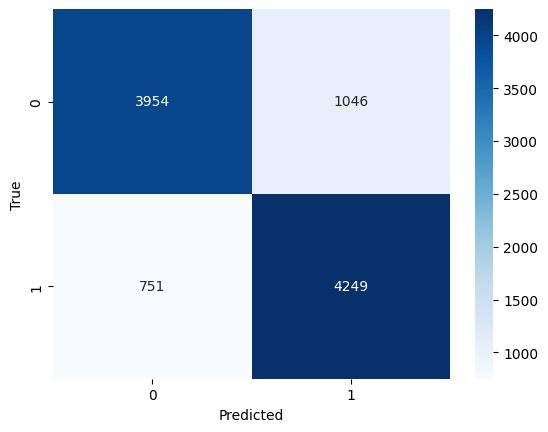

In [15]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

Exportamos las predicciones.

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
rf.fit(X_train_vectorized, y_train)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test = rf.predict(X_test_test)

df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("random_forest_300_iterations_random_search.csv")

# Ensamble

Vamos a probar un ensamble con gradient boosting, randomforest, adaboost y kneighbours.

Para eso entrenamos cada uno de ellos con RandomSearch cross validation. Empezando por el gradient boost.

In [19]:
base_classifier_gradient = GradientBoostingClassifier(random_state=SEED)

max_depth = list(range(1,6))

folds=5
params_search = {
    'n_estimators': list(range(100, 200)),
    'loss': ['log_loss', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.1, 0.5, 1.5],
    'max_depth': max_depth,
    'max_features': ['sqrt', 'log2', 10, 15]
}

kfoldcv = StratifiedKFold(n_splits=folds)


scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')
randomcv_gradient = RandomizedSearchCV(
    estimator=base_classifier_gradient,
    param_distributions = params_search,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=300
)

if exists("gb300iter.pkl") == False:
  randomcv_gradient.fit(X_train_vectorized, y_train)

  best_classifier_gradient = randomcv.best_estimator_

  joblib.dump(best_classifier_gradient, 'gb300iter.pkl', compress=9)
else:
  best_classifier_gradient = gb
  best_classifier_gradient.fit(X_train_vectorized, y_train)

realizamos predicciones y vemos las metricas.

              precision    recall  f1-score   support

    negativo       0.85      0.83      0.84      5000
    positivo       0.83      0.86      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

F1-Score: 0.8411679731100979
Accuracy: 0.8412
Precision: 0.84147542041509
Recall: 0.8412


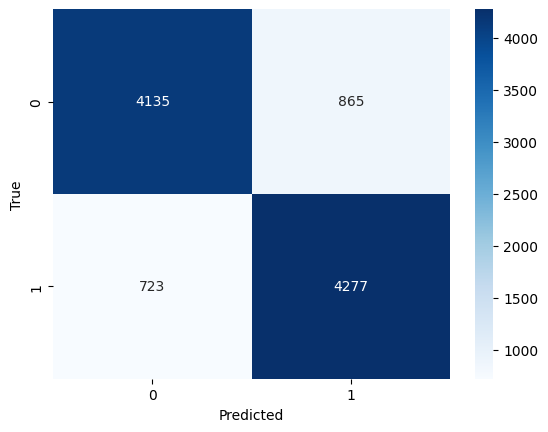

In [20]:
y_pred = best_classifier_gradient.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

Entrenamos Adaboost.

In [22]:
# Estaba tardando dos horas
base_classifier_ad = AdaBoostClassifier(random_state=SEED)


folds=5
params_search = {
    'n_estimators': list(range(40, 100)),
    'learning_rate': [0.1, 0.5, 1.0, 1.5],
}

kfoldcv = StratifiedKFold(n_splits=folds)


scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')
randomcv = RandomizedSearchCV(
    estimator=base_classifier_ad,
    param_distributions = params_search,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=10
)


if exists("ab10iter.pkl") == False:
  randomcv.fit(X_train_vectorized, y_train)

  best_classifier_ab = randomcv.best_estimator_

  joblib.dump(best_classifier_ab, 'ab10iter.pkl', compress=9)
else:
  best_classifier_ab = ab
  best_classifier_ab.fit(X_train_vectorized, y_train)

Predecimos el conjunto de test y vemos las métricas.

              precision    recall  f1-score   support

    negativo       0.83      0.77      0.80      5000
    positivo       0.79      0.84      0.81      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

F1-Score: 0.8068806763152845
Accuracy: 0.8071
Precision: 0.8085014480380894
Recall: 0.8070999999999999


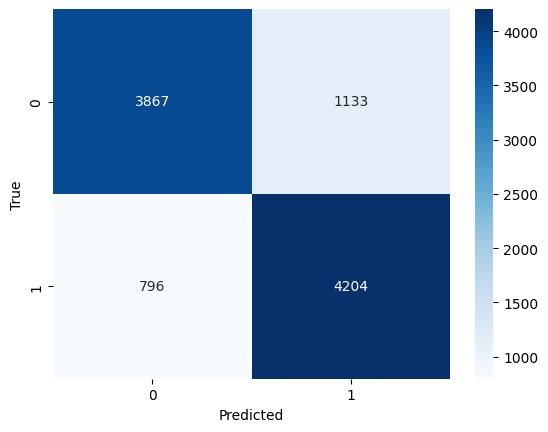

In [23]:
y_pred = best_classifier_ab.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

Buscamos los mejores hiperparametros de Kneighbors con Random Search.

In [25]:
base_classifier_kn = KNeighborsClassifier(n_jobs=-1)


folds=5
params_search = {
    #'n_neighbors': [5, 10, 20, 50],
    'n_neighbors': [5],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

kfoldcv = StratifiedKFold(n_splits=folds)


scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')
randomcv = RandomizedSearchCV(
    estimator=base_classifier_kn,
    param_distributions = params_search,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=1
)

if exists("kn.pkl") == False:
  randomcv.fit(X_train_vectorized, y_train)

  best_classifier_kn = randomcv.best_estimator_

  joblib.dump(best_classifier_kn, 'kn.pkl', compress=9)
else:
  best_classifier_kn = ab
  best_classifier_kn.fit(X_train_vectorized, y_train)

Muestro las metricas del mejor Kneighbors sobre el conjunto de test.

              precision    recall  f1-score   support

    negativo       0.83      0.77      0.80      5000
    positivo       0.79      0.84      0.81      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

F1-Score: 0.8068806763152845
Accuracy: 0.8071
Precision: 0.8085014480380894
Recall: 0.8070999999999999


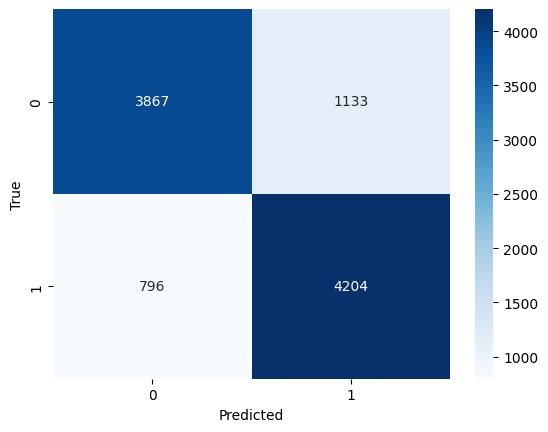

In [26]:
y_pred = best_classifier_kn.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

Creamos el ensamble con los modelos que entrenamos en esta notebook.

In [27]:
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('kn', kn), ('ab', ab)],
    voting='hard')

if exists("gb_rf_kn_ab_ensemble.pkl") == True:
  ensemble = joblib.load("gb_rf_kn_ab_ensemble.pkl")
else:
  ensemble.fit(X_train_vectorized, y_train)

Predecimos y mostramos las metricas sobre el conjunto de test. (Esto estaba tomando mucho tiempo en predecir y ademas se colgaba la notebook por lo que no volvimos a correr la celda).

In [ ]:
y_pred = ensemble.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

Exportamos las predicciones del ensamble sobre el conjunto de kaggle.

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test = ensemble.predict(X_test_test)

df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("voting_random_forest_gradient_boosting_k_neighbors_ada_boost_stop_words_tfidf_vectorizer_lemmatized.csv")

Exportamos el ensamble entrenado.

In [ ]:
joblib.dump(ensemble, 'gb_rf_kn_ab_ensemble.pkl', compress=9)

['gb_rf_kn_ab_ensemble.pkl']

Exportamos las predicciones del gradient boost sobre el conjunto de kaggle.

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test_gb = gb.predict(X_test_test)
df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test_gb
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("gradient_boosting_learning_rate05_exponential_depth5_sqrt_197estimators.csv")

# Otro ensamble

Ahora probamos con random forest, gradient boost y adaboost unicamente en el ensamble.

In [13]:
ensemble2 = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('ab', ab)],
    voting='hard')

Entrenamos el ensamble y mostramos las metricas sobre el conjunto de test.

In [14]:
ensemble2.fit(X_train_vectorized, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features='log2',
                                                     min_samples_split=0.2,
                                                     n_estimators=79,
                                                     random_state=13)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.5,
                                                         loss='exponential',
                                                         max_depth=5,
                                                         max_features='sqrt',
                                                         n_estimators=197,
                                                         random_state=13)),
                             ('ab',
                              AdaBoostClassifier(learning_rate=0.5,
                                                 n_estimators=97,
                                                 random_state=13))])

              precision    recall  f1-score   support

    negativo       0.85      0.80      0.83      5000
    positivo       0.81      0.86      0.84      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

F1-Score: 0.8319615884407827
Accuracy: 0.8321
Precision: 0.833197806805952
Recall: 0.8321000000000001


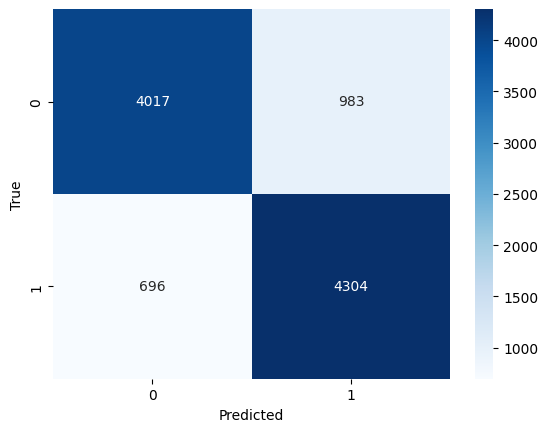

In [15]:
y_pred = ensemble2.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

Realizamos las predicciones sobre el conjunto de kaggle.

In [17]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test = ensemble2.predict(X_test_test)

df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("voting_random_forest_gradient_boosting_ada_boost_stop_words_tfidf_vectorizer_lemmatized.csv")

Exportamos el ensamble.

In [18]:
joblib.dump(ensemble2, 'gb_rf_ab_ensemble.pkl', compress=9)

['gb_rf_ab_ensemble.pkl']